In [1]:
import os
# Find the latest version of spark 3.0  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
spark_version = 'spark-3.0.3'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

!wget https://jdbc.postgresql.org/download/postgresql-42.2.9.jar

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("MachineLearningIntegration").config("spark.driver.extraClassPath","/content/postgresql-42.2.9.jar").getOrCreate()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [76.8 kB]
Hit:12 http://ppa.launchpad.net/cran/

In [4]:
# install prophet
!pip install prophet

In [5]:
# dependecies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from pandas import to_datetime
from pandas.tseries.offsets import DateOffset as DateOffset
from datetime import datetime
import itertools
import findspark
from pyspark.sql import SparkSession
from pyspark import SparkFiles

In [6]:
# access local data
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
# filepath
# path_1 = "Data/BicycleSales_2016-2021_cleaned.xlsx"
path_1 = '/content/gdrive/MyDrive/School/Georgia Tech/Data Science & Analytics Bootcamp/GT_DS_HW/Project-4_MachineLearningIntegration/Data/BicycleSales_2014-2021_redacted.xlsx'

# read data
sales_df = pd.read_excel(path_1)

sales_df

,SOrg.,DChl,Distribution Channel,Sold-to pt,Ship-to,Plnt,Matl Group,Material Group,Material,Month,Invoiced Quantity,Invoiced Quantity.1
0,10,11,E-Store,1025073,1025073,10,300,NaN,TB74255100,01/2014,2,EA
1,10,11,E-Store,1025073,1025073,10,300,NaN,TB72683000,01/2014,2,EA
2,10,11,E-Store,1025073,1025073,10,300,NaN,TB72683100,01/2014,2,EA
3,10,11,E-Store,1025073,1025073,10,300,NaN,TB35858000,01/2014,2,EA
4,10,11,E-Store,1025073,1025073,10,300,NaN,IB25400000,01/2014,2,EA
...,...,...,...,...,...,...,...,...,...,...,...,...
87018,10,20,Bicycle,1035929,1035929,30,300,NaN,SIB6988610,12/2021,1,EA
87019,10,20,Bicycle,1037697,1037697,30,300,NaN,TB74180100,12/2021,50,EA
87020,10,20,Bicycle,2000030,2000030,30,300,NaN,TB85975400,12/2021,5,EA
87021,10,20,Bicycle,2000030,2000030,30,300,NaN,TB00184900,12/2021,3,EA


In [8]:
# group and pivot invoiced quantity by date and material
# split Month into separate month and year components
sales_df[["Month", "Year"]] = sales_df["Month"].str.split("/", n=1, expand=True)

# create Date column with reordered Year/Month format
sales_df["Month"] = sales_df["Year"] + "-" + sales_df["Month"]

# group by date, sold-to, material
sales_gb_df = sales_df.groupby(
    ['Month', "Material"])[["Invoiced Quantity"]].sum()

sales_gb_df

Invoiced Quantity
Month   Material                     
2014-01 IB25400000                  4
        IB63464000                 56
        IB63829000                  3
        IB67445000                 20
        IB67447000                 64
...                               ...
2021-12 TB96908400                 17
        TB96909000                 94
        TB96909200                  7
        TB96909300                 12
        TB96910100                 45

[25263 rows x 1 columns]

In [9]:
# pivot sold to and material
sales_pivot_df = pd.pivot_table(sales_gb_df,
                           values = 'Invoiced Quantity',
                           index = 'Month',
                           columns = 'Material',
                           aggfunc=np.sum,
                           fill_value = 0
                                )

sales_pivot_df = sales_pivot_df.reset_index()
sales_pivot_df['Month'] = to_datetime(sales_pivot_df['Month'])
sales_pivot_df = sales_pivot_df.set_index(['Month'])

sales_pivot_df

Material,IB00026200,IB00026400,IB00026500,IB00041800,IB00095000,IB00095100,IB00099900,IB00100000,IB00136200,IB00137300,...,TB96909000,TB96909100,TB96909200,TB96909300,TB96910000,TB96910100,TB96962000,TB96962100,TB97613100,TB97613200
Month,,,,,,,,,,,,,,,,,,,,,
2014-01-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-02-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-03-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-04-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-05-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-01,0,0,0,0,0,0,30,0,0,126,...,20,0,0,0,0,0,42,0,0,0
2021-09-01,0,0,0,0,0,0,20,0,126,0,...,0,0,0,0,0,0,0,0,0,0
2021-10-01,0,0,0,0,0,0,60,0,0,0,...,0,0,0,0,0,0,0,15,0,0


In [18]:
# select single SKU to examine
sales_1_df = sales_pivot_df[['TB96805000']]
sales_1_df.rename(columns={'TB96805000':'Sales'}, inplace = True)
sales_1_df

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Material,Sales
Month,
2014-01-01,0
2014-02-01,0
2014-03-01,125
2014-04-01,35
2014-05-01,28
...,...
2021-08-01,3127
2021-09-01,0
2021-10-01,0


In [102]:
# dataframe format for prophet
df = sales_1_df.reset_index()
df.columns = ['ds', 'y']
df['floor'] = 0
df['cap'] = 4000
df

,ds,y,floor,cap
0,2014-01-01,0,0,30000
1,2014-02-01,0,0,30000
2,2014-03-01,125,0,30000
3,2014-04-01,35,0,30000
4,2014-05-01,28,0,30000
...,...,...,...,...
91,2021-08-01,3127,0,30000
92,2021-09-01,0,0,30000
93,2021-10-01,0,0,30000
94,2021-11-01,0,0,30000


### Prohpet

In [71]:
# fit prophet model and predict
m = Prophet()

m.fit(df)
future = m.make_future_dataframe(periods=24, freq='M')

fcst = m.predict(future)

fcst

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-01-01,-33.440638,-545.344707,445.311354,-33.440638,-33.440638,-31.170015,-31.170015,-31.170015,-31.170015,-31.170015,-31.170015,0.0,0.0,0.0,-64.610653
1,2014-02-01,-27.674838,-546.236238,414.965539,-27.674838,-27.674838,-24.289304,-24.289304,-24.289304,-24.289304,-24.289304,-24.289304,0.0,0.0,0.0,-51.964142
2,2014-03-01,-22.467019,-562.085311,381.057073,-22.467019,-22.467019,-69.190047,-69.190047,-69.190047,-69.190047,-69.190047,-69.190047,0.0,0.0,0.0,-91.657066
3,2014-04-01,-16.701220,-449.352052,496.461465,-16.701220,-16.701220,44.038387,44.038387,44.038387,44.038387,44.038387,44.038387,0.0,0.0,0.0,27.337167
4,2014-05-01,-11.121414,-362.551949,610.565458,-11.121414,-11.121414,133.529125,133.529125,133.529125,133.529125,133.529125,133.529125,0.0,0.0,0.0,122.407711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2023-07-31,617.164739,-70.219475,908.280334,617.164726,617.164755,-214.723919,-214.723919,-214.723919,-214.723919,-214.723919,-214.723919,0.0,0.0,0.0,402.440820
116,2023-08-31,622.930539,-97.501646,898.460665,622.930524,622.930556,-227.816767,-227.816767,-227.816767,-227.816767,-227.816767,-227.816767,0.0,0.0,0.0,395.113772
117,2023-09-30,628.510345,215.018417,1159.133783,628.510329,628.510363,73.912989,73.912989,73.912989,73.912989,73.912989,73.912989,0.0,0.0,0.0,702.423334
118,2023-10-31,634.276145,775.961572,1703.379467,634.276127,634.276163,602.890542,602.890542,602.890542,602.890542,602.890542,602.890542,0.0,0.0,0.0,1237.166687


In [72]:
# renaming output dataframe colummns
prophet_df = fcst[{'ds', 'yhat'}]
prophet_df.columns = ['Prophet', 'Month']
# changing data type to integer
prophet_df['Prophet'] = prophet_df['Prophet'].round(decimals=0)
prophet_df['Prophet'] = prophet_df['Prophet'].apply(np.int64)
prophet_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Prophet,Month
0,-65,2014-01-01
1,-52,2014-02-01
2,-92,2014-03-01
3,27,2014-04-01
4,122,2014-05-01
...,...,...
115,402,2023-07-31
116,395,2023-08-31
117,702,2023-09-30
118,1237,2023-10-31


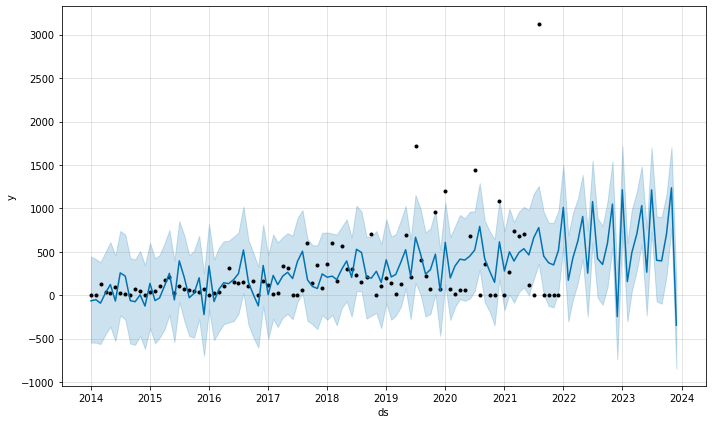

In [73]:
# plot
fig = m.plot(fcst)

In [74]:
# set variables for cross validation
cutoffs = pd.to_datetime(['2017-12-01'])
horizon='731 days'
period='30 days'
parallel='processes'

# cross validation
df_cv = cross_validation(m, cutoffs=cutoffs, horizon=horizon, period=period, parallel=parallel)

# performance
df_p = performance_metrics(df_cv, rolling_window=1)

df_p

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f2c60214ed0>


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,730 days,149508.054335,386.662714,236.930151,3.141955,0.540087,0.714955,0.416667


In [75]:
# Hyperparameter tuning
param_grid = {  
    'changepoint_prior_scale': [0.001, .005, 0.01, 0.05, 0.1],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10],
    'seasonality_mode': ['additive', 'multiplicative'],
    'growth': ['logistic']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon=horizon, period=period, parallel=parallel)
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses

tuning_results

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f2c601f8990>
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f2c603f0b50>
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f2c6155b810>
INFO:prophet:Disabling weekly seasonality. Run prophet 

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,growth,rmse
0,0.001,0.01,additive,logistic,380.742856
1,0.001,0.01,multiplicative,logistic,414.815394
2,0.001,0.10,additive,logistic,373.899023
3,0.001,0.10,multiplicative,logistic,411.778643
4,0.001,1.00,additive,logistic,421.411035
5,0.001,1.00,multiplicative,logistic,519.067727
6,0.001,10.00,additive,logistic,374.095294
7,0.001,10.00,multiplicative,logistic,587.639873
8,0.005,0.01,additive,logistic,371.359190
9,0.005,0.01,multiplicative,logistic,370.437434


In [86]:
# Identify best hyperparameter
best_parameters = tuning_results.iloc[tuning_results['rmse'].idxmin(),:]
cps = best_parameters['changepoint_prior_scale']
sps = best_parameters['seasonality_prior_scale']
sm = best_parameters['seasonality_mode']
growth = best_parameters['growth']
best_parameters

changepoint_prior_scale        0.005
seasonality_prior_scale         10.0
seasonality_mode            additive
growth                      logistic
rmse                       367.05949
Name: 14, dtype: object

In [124]:
# model with best hyperameters
m = Prophet(seasonality_mode=sm, changepoint_prior_scale=cps, seasonality_prior_scale=sps, growth=growth)

m.fit(df)
future = m.make_future_dataframe(periods=24, freq='M')
future['floor'] = 0
future['cap'] = 3500

fcst_tuned = m.predict(future)

fcst

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-01-01,-33.440638,-545.344707,445.311354,-33.440638,-33.440638,-31.170015,-31.170015,-31.170015,-31.170015,-31.170015,-31.170015,0.0,0.0,0.0,-64.610653
1,2014-02-01,-27.674838,-546.236238,414.965539,-27.674838,-27.674838,-24.289304,-24.289304,-24.289304,-24.289304,-24.289304,-24.289304,0.0,0.0,0.0,-51.964142
2,2014-03-01,-22.467019,-562.085311,381.057073,-22.467019,-22.467019,-69.190047,-69.190047,-69.190047,-69.190047,-69.190047,-69.190047,0.0,0.0,0.0,-91.657066
3,2014-04-01,-16.701220,-449.352052,496.461465,-16.701220,-16.701220,44.038387,44.038387,44.038387,44.038387,44.038387,44.038387,0.0,0.0,0.0,27.337167
4,2014-05-01,-11.121414,-362.551949,610.565458,-11.121414,-11.121414,133.529125,133.529125,133.529125,133.529125,133.529125,133.529125,0.0,0.0,0.0,122.407711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2023-07-31,617.164739,-70.219475,908.280334,617.164726,617.164755,-214.723919,-214.723919,-214.723919,-214.723919,-214.723919,-214.723919,0.0,0.0,0.0,402.440820
116,2023-08-31,622.930539,-97.501646,898.460665,622.930524,622.930556,-227.816767,-227.816767,-227.816767,-227.816767,-227.816767,-227.816767,0.0,0.0,0.0,395.113772
117,2023-09-30,628.510345,215.018417,1159.133783,628.510329,628.510363,73.912989,73.912989,73.912989,73.912989,73.912989,73.912989,0.0,0.0,0.0,702.423334
118,2023-10-31,634.276145,775.961572,1703.379467,634.276127,634.276163,602.890542,602.890542,602.890542,602.890542,602.890542,602.890542,0.0,0.0,0.0,1237.166687


In [120]:
# renaming output dataframe
prophet_tuned_df = fcst_tuned[{'ds', 'yhat'}]
prophet_tuned_df.columns = ['Prophet_tuned', 'Month']

prophet_tuned_df['Prophet_tuned'] = prophet_tuned_df['Prophet_tuned'].round(decimals=0)
prophet_tuned_df['Prophet_tuned'] = prophet_tuned_df['Prophet_tuned'].apply(np.int64)

prophet_tuned_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Prophet_tuned,Month
0,-47,2014-01-01
1,-49,2014-02-01
2,-90,2014-03-01
3,34,2014-04-01
4,122,2014-05-01
...,...,...
115,-118,2023-07-31
116,-105,2023-08-31
117,111,2023-09-30
118,684,2023-10-31


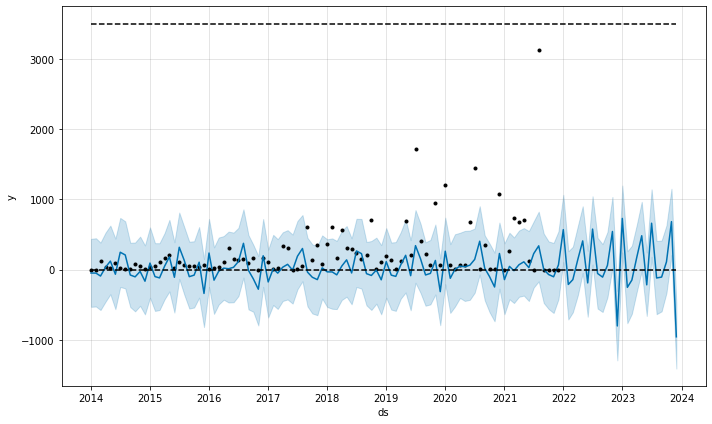

In [121]:
# plot
fig = m.plot(fcst_tuned)

In [122]:
# performance
df_cv = cross_validation(m, cutoffs=cutoffs, horizon=horizon, period=period, parallel=parallel)

df_p = performance_metrics(df_cv, rolling_window=1)
df_p

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f2c6040b7d0>


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,730 days,135005.104729,367.430408,272.058297,4.873558,0.728088,0.783445,0.25


### load to postgres RDS

In [114]:
#Create PySpark DataFrame from Pandas
prophet_sparkDF=spark.createDataFrame(prophet_df) 
prophet_sparkDF.printSchema()
prophet_sparkDF.show()

root
 |-- Prophet: long (nullable = true)
 |-- Month: timestamp (nullable = true)

+-------+-------------------+
|Prophet|              Month|
+-------+-------------------+
|    -65|2014-01-01 00:00:00|
|    -52|2014-02-01 00:00:00|
|    -92|2014-03-01 00:00:00|
|     27|2014-04-01 00:00:00|
|    122|2014-05-01 00:00:00|
|    -67|2014-06-01 00:00:00|
|    257|2014-07-01 00:00:00|
|    220|2014-08-01 00:00:00|
|    -62|2014-09-01 00:00:00|
|    -75|2014-10-01 00:00:00|
|      4|2014-11-01 00:00:00|
|   -125|2014-12-01 00:00:00|
|    136|2015-01-01 00:00:00|
|    -62|2015-02-01 00:00:00|
|    -32|2015-03-01 00:00:00|
|    107|2015-04-01 00:00:00|
|    252|2015-05-01 00:00:00|
|    -54|2015-06-01 00:00:00|
|    396|2015-07-01 00:00:00|
|    204|2015-08-01 00:00:00|
+-------+-------------------+
only showing top 20 rows



In [115]:
#Create PySpark DataFrame from Pandas
sales_1_sparkDF=spark.createDataFrame(sales_1_df.reset_index()) 
sales_1_sparkDF.printSchema()
sales_1_sparkDF.show()

root
 |-- Month: timestamp (nullable = true)
 |-- Sales: long (nullable = true)

+-------------------+-----+
|              Month|Sales|
+-------------------+-----+
|2014-01-01 00:00:00|    0|
|2014-02-01 00:00:00|    0|
|2014-03-01 00:00:00|  125|
|2014-04-01 00:00:00|   35|
|2014-05-01 00:00:00|   28|
|2014-06-01 00:00:00|   97|
|2014-07-01 00:00:00|   27|
|2014-08-01 00:00:00|   13|
|2014-09-01 00:00:00|    8|
|2014-10-01 00:00:00|   74|
|2014-11-01 00:00:00|   50|
|2014-12-01 00:00:00|    4|
|2015-01-01 00:00:00|   34|
|2015-02-01 00:00:00|   49|
|2015-03-01 00:00:00|  106|
|2015-04-01 00:00:00|  171|
|2015-05-01 00:00:00|  214|
|2015-06-01 00:00:00|   25|
|2015-07-01 00:00:00|  106|
|2015-08-01 00:00:00|   73|
+-------------------+-----+
only showing top 20 rows



In [116]:
#Create PySpark DataFrame from Pandas
prophet_tuned_sparkDF=spark.createDataFrame(prophet_tuned_df) 
prophet_tuned_sparkDF.printSchema()
prophet_tuned_sparkDF.show()

root
 |-- Prophet_tuned: long (nullable = true)
 |-- Month: timestamp (nullable = true)

+-------------+-------------------+
|Prophet_tuned|              Month|
+-------------+-------------------+
|          -46|2014-01-01 00:00:00|
|          -47|2014-02-01 00:00:00|
|          -89|2014-03-01 00:00:00|
|           35|2014-04-01 00:00:00|
|          124|2014-05-01 00:00:00|
|          -63|2014-06-01 00:00:00|
|          250|2014-07-01 00:00:00|
|          211|2014-08-01 00:00:00|
|          -74|2014-09-01 00:00:00|
|         -100|2014-10-01 00:00:00|
|          -23|2014-11-01 00:00:00|
|         -162|2014-12-01 00:00:00|
|           96|2015-01-01 00:00:00|
|          -96|2015-02-01 00:00:00|
|         -115|2015-03-01 00:00:00|
|           50|2015-04-01 00:00:00|
|          184|2015-05-01 00:00:00|
|         -106|2015-06-01 00:00:00|
|          321|2015-07-01 00:00:00|
|          134|2015-08-01 00:00:00|
+-------------+-------------------+
only showing top 20 rows



In [117]:
# Configure settings for RDS
mode = "overwrite"
jdbc_url="jdbc:postgresql://database-1.cc8swew422eu.us-east-1.rds.amazonaws.com:5432/postgres"
config = {"user":"pgadmin", 
          "password": "postgres", 
          "driver":"org.postgresql.Driver"}

In [118]:
# Write DataFrame to prophet table in RDS

prophet_sparkDF.write.jdbc(url=jdbc_url, table='prophet', mode=mode, properties=config)
sales_1_sparkDF.write.jdbc(url=jdbc_url, table='sales', mode=mode, properties=config)
prophet_tuned_sparkDF.write.jdbc(url=jdbc_url, table='prophet_tuned', mode=mode, properties=config)